In [12]:
import torch
import torch_geometric
import pathpyG as pp
from typing import Iterable, Union, Any, Optional
import csv
from HotVisFunctions import *



## Berechnung der Verschiebung aller Knoten in der 2. Schleife von HotVis()

Die Verschiebung (`displacement`) wird mithilfe eines Einsum-Produkts berechnet:

```python
displacement = torch.einsum('ijk,ij->ik', delta, 
                            (A * distance / force - force**2 / distance**2))
```

### Definition von (`delta`)

`delta` ist definiert als eine 3D-Matrix der Form:

`delta` = 
\begin{bmatrix}
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[1] \\
    \text{pos}[2] - \text{pos}[1] \\
    \text{pos}[3] - \text{pos}[1] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[1] \\
  \end{bmatrix}
  & 
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[2] \\
    \text{pos}[2] - \text{pos}[2] \\
    \text{pos}[3] - \text{pos}[2] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[2] \\
  \end{bmatrix}
  &
  \cdots
  &
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[n] \\
    \text{pos}[2] - \text{pos}[n] \\
    \text{pos}[3] - \text{pos}[n] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[n] \\
  \end{bmatrix}
\end{bmatrix}

Jeder hier dargestellte Block berechnet sich dabei durch ```positions - positions[i]```

### Form des 3. Parameters

Der Ausdruck

$\text{A} \cdot \frac{\text{distance}}{\text{force}} - \frac{\text{force}^2}{\text{distance}^2}$

ist eine $n \times n$-Matrix.

### Elementweise Multiplikation

Beide Werte aller $j$ Zeilen der $j \times k$-Blöcke ($i$ stück) aus ```delta```, berechnet durch ```positions - positions[i]```, werden mit dem jeweiligen Wert aus ```A[i, j]``` elementweise multipliziert. Danach wird über den Index ```j``` summiert, also über die Zeilen der Blöcke.

## Berechnung der Änderung der Positionen

Die Änderung der Positionen wird berechnet durch:

```python
delta_positions = torch.einsum('ij,ij->ij', displacement, length_with_temp / length)
```

```delta_positions``` ist eine $ n \times 2 $-Matrix. Die $x$- und $y$-Koordinaten jeder Verschiebung werden mit dem entsprechenden Skalar aus der $n \times 1$-Matrix $\frac{\text{length\_with\_temp}}{\text{length}}$ multipliziert.



# Testen der HotVis-Funktion

Laden des Graphen

In [14]:
graph = pp.io.read_csv_temporal_graph('graphs/synthetic_graph/temporal_clusters_real_kregular.tedges', is_undirected = True, timestamp_format='%S')

Eigentliche Funktion

In [15]:
initial_positions = torch.rand((graph.n, 2))*1000
pos_slow = initial_positions.clone()
pos_fast = initial_positions.clone()

layout_slow, graph_slow, pos_slow, A_slow  = HotVisSlow(graph, orders=2, iterations=50000, delta=1, alpha=[1, 1], initial_positions=pos_slow)
layout_fast, graph_fast, pos_fast, A_fast  = HotVis(graph, orders=2, iterations=50000, delta=1, alpha=[1, 1], initial_positions=pos_fast)


100%|██████████| 50000/50000 [00:06<00:00, 7891.14it/s]


Plotte den Graphen

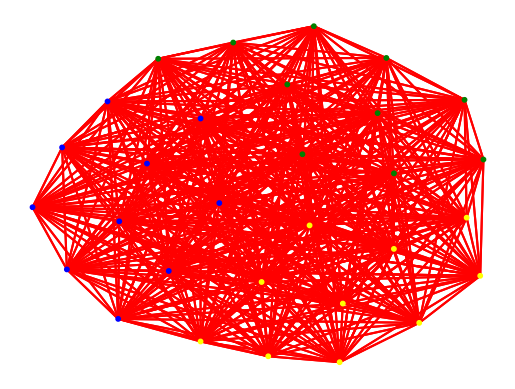

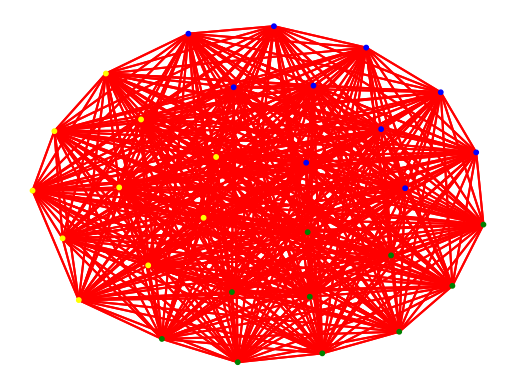

In [16]:
# read colors
colors = {}
with open('graphs/synthetic_graph/colors.csv', mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Überspringt die Kopfzeile
    for row in reader:
        number, color = row
        colors[number] = color
style = {}
style['node_color'] = colors
style['node_size'] = 10
style['edge_size'] = 0.1

pp.plot(graph.to_static_graph(), layout=layout_fast, backend='matplotlib' ,**style)
pp.plot(graph.to_static_graph(), layout=layout_slow, backend='matplotlib' ,**style)


# Test Metriken

Einfachen Graphen zum Nachrechnen erstellen.

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 1042.06it/s]

('a', 'b')
('a', 'c')
('a', 'd')
('b', 'a')
('b', 'c')
('b', 'd')
('c', 'b')
('c', 'd')
('d', 'c')
('a', 'b', 'c')
('b', 'a', 'c')
('b', 'a', 'd')
('c', 'b', 'a')
('c', 'b', 'a', 'd')


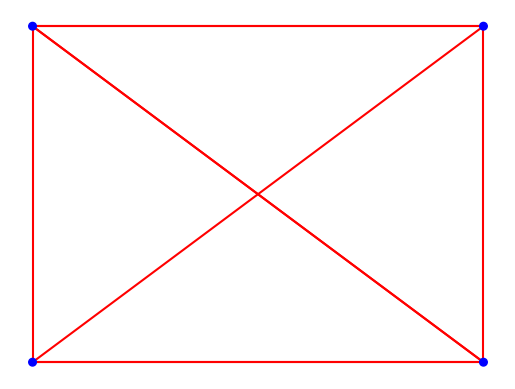

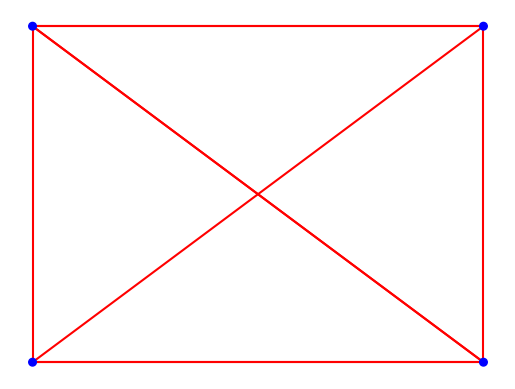

In [70]:
tedges = [('a', 'b', 1),('a', 'b', 2), ('b', 'a', 3), ('b', 'c', 3), ('d', 'c', 4), ('a', 'b', 4), ('c', 'b', 4),
              ('c', 'd', 5), ('b', 'a', 5), ('c', 'b', 6), ('a', 'c', 6), ('b', 'd', 6), ('a', 'd', 6)]
test_graph = pp.TemporalGraph.from_edge_list(tedges)
test_layout= {'a':[0,0], 'b':[1,0], 'c':[0,1], 'd':[1,1]}

# create PathData object with same structure
m = pp.MultiOrderModel.from_temporal_graph(test_graph, 1, 6, cached=True)
test_paths = pp.PathData(test_graph.mapping)

for i in range(2,7):
   for node in list(m.layers[i].nodes):
        if(len(list(node)) == len(set(list(node)))):
                test_paths.append_walk(list(node))

for i in range(test_paths.num_paths):
     print(test_paths.get_walk(i))

pp.plot(test_graph.to_static_graph(), layout=test_layout, backend="matplotlib")

test_m = pp.MultiOrderModel.from_PathData(test_paths, 2, cached=True)
pp.plot(test_m.layers[1], layout=test_layout, backend="matplotlib")

### Barycentre

In [71]:
print(barycentre(test_layout))
print(barycentre(test_layout, ['a']))

tensor([0.5000, 0.5000], dtype=torch.float64)
tensor([0., 0.], dtype=torch.float64)


##### Überprüfung Barycentre

Der Barycenter ist hier $\frac{1}{4} \cdot [0,0] + [1,0] + [0,1] + [1,1] = [0.5, 0.5] $. Damit ist der Wert also richtig.

### Closeness Centrality

In [19]:
print(closeness_centrality_paths_slow(test_paths))
print(closeness_centrality_paths(test_paths))

{'a': 2.625, 'b': 2.4571428571428573, 'c': 2.0821428571428573, 'd': 2.2}
{'a': 2.625, 'b': 2.4571428298950195, 'c': 2.0821428298950195, 'd': 2.200000047683716}


/tmp/ipykernel_1025/4183654831.py:284: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  path_indices = torch.tensor(paths.mapping.to_idxs(path))


##### Überprüfung Closeness Centrality
Die Formel für die Closeness Centrality ist 

$ CC(v) := \sum_{w \neq v \in V} \frac{\sum_{p \in S} \delta_w(p) \delta_v(p)}{\sum_{p \in S, w \in p} \text{dist}(v, w; p)}.$

Zunächst berechnen wir die Closeness Centrality für $a$:
Es gibt folgende Pfade in denen $a$ und $b$ vorkommen:

$(a, b), (b, a), (a, b, c), (b, a, c), (b, a, d), (c, b, a), (c, b, a, d)$

In jedem ist der Pfade ist der Abstand zwischen $a$ und $b$ gleich eins. Damit ergibt sich für den Summand mit $w=b$: $\frac{7}{7}$.
Es gibt folgende Pfade in denen $a$ und $c$ vorkommen:

$(a, c), (a, b, c), (b, a, c), (c, b, a), (c, b, a, d)$

In zwei Fällen ist der Abstand zwischen $a$ und $c$ eins und in drei Fällen zwei. Damit ergibt sich für den Summand mit $w=c$: $\frac{5}{2 \cdot 1 + 3 \cdot 2} = \frac{5}{8}$.
Es gibt folgende Pfade in denen $a$ und $d$ vorkommen:

$(a,d), (b, a, d), (c, b, a, d)$

In allen Fällen ist der Abstand zwischen $a$ und $d$ eins. Damit ergebt sich für den Summand mit $w=d$: $\frac{3}{3}$.
Damit gilt:

$CC(a)=1+\frac{5}{8} + 1 = 2.625$

Analog ergibt sich

$CC(b) = \frac{7}{7}+\frac{6}{7}+\frac{3}{5} = 2.457$

$CC(c) = \frac{5}{8}+\frac{6}{7}+\frac{3}{5} = 2.08$

$CC(d) = \frac{3}{3}+\frac{3}{5}+\frac{3}{5} = 2.2$

### Closeness Eccentricity

In [73]:
print(closeness_centrality_paths(paths_graph))
print(closeness_eccentricity(test_graph, test_layout, percentile=0.1, delta=1))
print(closeness_eccentricity(test_paths, test_layout, percentile=0.1, delta=1))

{'a': 2.6666666666666665, 'b': 3.0, 'c': 2.6666666666666665, 'd': 3.0}


100%|██████████| 6/6 [00:00<00:00, 1592.47it/s]


100%|██████████| 2/2 [00:00<00:00, 2439.26it/s]

tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)


##### Überprüfung Closeness Eccentricity
Wir Rechnen den Wert für ```test_paths``` nach. Wir gehen nach der Überprüfung oben davon aus, dass die von ```loseness_centrality_path```zurückgegebenen Werte korrekt sind. Mit der Formel

$\Delta(\gamma) := \frac{\sum_{u_i \in T_{\gamma}} \| Pos[u_i] - B(V) \| \cdot |V|}{|T_{\gamma}| \cdot \sum_{v \in V} \| Pos[v] - B(V) \|} \in [0, 1]$, 

wobei $T_{\gamma}$ die Menge der Knoten mit Closeness Centrality im oberen $\gamma$-Percentile ist, ergibt sich für $\gamma = 0.1$:

$\Delta(0.1) = \frac{(\sqrt{0.5}+ \sqrt{0.5}) \cdot 4}{2 \cdot (\sqrt{0.5}+ \sqrt{0.5}+ \sqrt{0.5}+ \sqrt{0.5})} = 1$.

Damit stimmt der von der Funktion zurückgegebene Wert.

### Causal Path Dispersion

In [74]:
print(causal_path_dispersion(test_graph, test_layout, steps=[3], runs=[100]))
shortest_paths = get_shortest_paths_as_pathdata(test_graph, 1)
for idx in range(shortest_paths.num_paths):
    print(shortest_paths.get_walk(idx))
print(causal_path_dispersion(shortest_paths, test_layout))
print(causal_path_dispersion(test_paths, test_layout))

100%|██████████| 100/100 [00:00<00:00, 4293.04it/s]


tensor(0.8260, dtype=torch.float64)


100%|██████████| 6/6 [00:00<00:00, 2153.13it/s]

('a', 'b')
('a', 'c')
('a', 'd')
('b', 'a')
('b', 'c')
('b', 'd')
('c', 'b')
('c', 'd')
('d', 'c')
('c', 'b', 'a')
tensor(0.8219, dtype=torch.float64)
tensor(0.8701, dtype=torch.float64)


##### Überprüfung Causal Path Dispersion

Wir rechnen die Causal Path Dispersion für ```shortest_paths```nach. Die Formel für die Causal Path Dispersion ist

$\sigma = \frac{\sum_{p \in S} \sum_{u_i \in p} \left\| Pos[u_i] - B(p) \right\| \cdot |V|}{\left( \sum_{p \in S}{|p|} \right) \cdot \sum_{v_i \in V} \left\| Pos[v_i] - B(V) \right\|} \in [0,1]$.

Für die Pfade ergibt sich folgender Summand im Zähler:

- $(a,b): 1$
- $(a,c): 1$
- $(a,d): \sqrt(2)$
- $(b,a): 1$
- $(b,c): \sqrt(2)$
- $(b,d): 1$
- $(c,b,a): \sqrt{\frac{2}{9}} + 2 \cdot \sqrt{\frac{5}{9}}$
- $(c,b): \sqrt(2)$
- $(c,d): 1$
- $(d,c): 1$

Damit ergibt sich für den Zähler $4 \cdot (6+ 3\cdot \sqrt{2} + \sqrt{\frac{2}{9}} + 2 \cdot \sqrt{\frac{5}{9}}) = 48.82$.

Der Nenner berechnet sich aus $21 \cdot 4 \cdot \sqrt{0.5} = 59.397$

Damit ergibt sich für das Ergebnis $0.821$, was mit dem Ergbenis der Funktion übereinstimmt.





### Edge Crossing

In [75]:
print(edge_crossing(test_graph, test_layout))
print(edge_crossing(test_paths, test_layout))

tensor(1.)
tensor(1.)


##### Überprüfung Edgecrossing
Die Warte lassen sich leicht durch einen Blick auf die Plots der Graphen überprüfen.

### Cluster Distance Ratio

In [24]:
cluster = [['a', 'b'], ['c', 'd']]
print(cluster_distance_ratio(test_graph, cluster, test_layout))

tensor([0.6180, 0.6180])


##### Überprüfung Cluster Distance Ratio

Der Barycentre von ```['a', 'b']``` ist ```[0, 0.5]```. Damit der Abstand von ```'a'```und ```'b'``` zu ```[0, 0.5]``` jeweils 0.5. Damit Beträgt auch der durchschnittliche Abstand aller Knoten des Clusters zu ```[0, 0.5]``` 0.5. 
Der Abstand von ```'c'```und ```'d'``` zu ```[0, 0.5]``` ist jeweils $\sqrt{1^2 + 0.5^2} \approx 1.118 $. Der durchschnittliche Abstand aller Knoten zu ```[0, 0.5]``` beträgt dann $\frac{2 \cdot 0.5 + 2 \cdot 1.118}{4} \approx 0.809$. Der Wert für das Cluster ```['a', 'b']``` beträgt somit $\frac{0.5}{0.809} = 0.618$.
Der Barycentre von ```['c', 'd']``` ist ```[1, 0.5]```. Damit der Abstand von ```'c'```und ```'d'``` zu ```[1, 0.5]``` jeweils 0.5. Damit Beträgt auch der durchschnittliche Abstand aller Knoten des Clusters zu ```[1, 0.5]``` 0.5. 
Der Abstand von ```'a'```und ```'b'``` zu ```[1, 0.5]``` ist jeweils $\sqrt{1^2 + 0.5^2} \approx 1.118 $. Der durchschnittliche Abstand aller Knoten zu ```[1, 0.5]``` beträgt dann $\frac{2 \cdot 0.5 + 2 \cdot 1.118}{4} \approx 0.809$. Der Wert für das Cluster ```['c', 'd']``` beträgt somit $\frac{0.5}{0.809} = 0.618$.
Somit stimmt der berechnete Wert.

# Testen einer alternativen Berechnung der Dispersion

In [25]:
def causal_path_dispersion_test(data, layout, delta=1, steps: list = [], runs : list = []):
    if isinstance(data, pp.TemporalGraph):
        if len(steps) == 0:
            steps = [max(3, int(data.n/3))]
        if len(runs)==0:
            runs = [int(data.n/2)]
        paths = random_walk_temporal_graph(data, delta=delta, steps=steps, runs=runs)
    elif isinstance(data, pp.PathData):
        paths = data
    else:
        return 0
    
    numerator = 0
    multiplicator = 0
    for i in range(paths.num_paths):
        path = paths.get_walk(i)
        # get positions of nodes of path
        position_nodes = torch.tensor([layout[node] for node in path])
        # Add the summand of the corresponding path to the counter
        numerator += torch.sum(torch.norm(position_nodes - barycentre(layout, path), dim=1))
        multiplicator += len(path)
    numerator *= len(layout)
    # calculate denominator
    positions = torch.tensor(list(layout.values()))
    denominator = torch.sum(torch.norm( positions - barycentre(layout), dim=1)) * multiplicator
    return numerator/denominator

print(causal_path_dispersion_test(test_graph, test_layout))

100%|██████████| 2/2 [00:00<00:00, 144.62it/s]


tensor(0.7071, dtype=torch.float64)


# Test, ob beide Funktionen unterschiedlich, wegen numerischen Ungenauigkeiten

In [26]:
def HotVisCompare(data: pp.TemporalGraph|pp.PathData, orders: int, iterations: int, delta: int, 
           alpha: torch.Tensor | None = None, initial_positions: torch.Tensor | None = None, force: int = 1) -> torch.Tensor:
    
    if(isinstance(data, pp.TemporalGraph)):   
        mo_model = pp.MultiOrderModel.from_temporal_graph(data, delta=delta, max_order=orders)
    elif(isinstance(data, pp.PathData)):
        mo_model = pp.MultiOrderModel.from_PathData(data, max_order=orders)
    else:
        return
    

    if alpha is None:
        alpha = torch.ones(orders)
    if initial_positions is None:
        initial_positions = torch.rand((mo_model.layers[1].n, 2))
    A = torch.zeros((mo_model.layers[1].n, mo_model.layers[1].n))

    # iterate over higher orders
    for i in range(orders):
        # get higher order graph
        ho_graph = mo_model.layers[i+1]

        # for edge ((v_0, ..., v_{k-1}), (v_1,...,v_k)) get nodes v_0 and v_k
        nodes_start = ho_graph.data.node_sequence[:, 0][ho_graph.data.edge_index[0]]
        nodes_end = ho_graph.data.node_sequence[:, -1][ho_graph.data.edge_index[1]]
        # stack tensors for later use
        indices = torch.stack((nodes_start, nodes_end), dim=0)
        # get edge weights
        edge_weights = ho_graph['edge_weight']
        # remove duplicates while summing their weights up
        indices, edge_weights = torch_geometric.utils.coalesce(indices, edge_weights)
        # add weights to A
        A[indices[0], indices[1]] += alpha[i] * edge_weights

##################################################################################

    A_slow = torch.zeros((mo_model.layers[1].n, mo_model.layers[1].n))

    for i in range(orders):
        ho_graph = mo_model.layers[i+1]
        # iterate over edges of higher order graph
        for edge in ho_graph.edges:
            # for edge ((v_0, ..., v_{k-1}), (v_1,...,v_k)) get nodes v_0 and v_k
            # for i == 0, edge has form (v_0, v_1)
            if(i == 0):
                node_start = edge[0]
                node_end = edge[1]
            # for i > 0, edge has form ((v_0, ..., v_{i-1}), (v_1,...,v_i))
            else:
                node_start = edge[0][0]
                node_end = edge[1][-1]

            # get indices of the nodes
            index_node_start = mo_model.layers[1].mapping.to_idx(node_start)
            index_node_end = mo_model.layers[1].mapping.to_idx(node_end)

            # add to A
            A_slow[index_node_start, index_node_end] += alpha[i] * ho_graph['edge_weight', edge[0], edge[1]]

    print(A==A_slow)

###############################################################################################################
    positions = initial_positions.clone()
    positions_slow = initial_positions.clone()
    t = 0.1
    dt = dt = t / float(iterations + 1)

    delta = torch.zeros((positions.shape[0], positions.shape[0], positions.shape[1]))
    delta_slow = torch.zeros((positions.shape[0], positions.shape[0], positions.shape[1]))
    displacement_slow = torch.zeros((mo_model.layers[1].n, 2))
    # the inscrutable (but fast) version

    for _ in pp.tqdm(range(iterations)):
        # matrix of difference between points
        delta = positions[torch.newaxis, :, :] - positions[:, torch.newaxis, :]
        # distance between points
        distance = torch.linalg.norm(delta, dim=-1)
        # enforce minimum distance of 0.01
        torch.clip(distance, 0.01, None, out=distance)
        # calculate displacement of all nodes
        displacement = torch.einsum('ijk,ij->ik', delta,
                                (A * distance / force - force**2 / distance**2))
        # calculate length of displacements
        length = torch.linalg.norm(displacement, dim=-1)
        # enforce minimum length of 0.01
        length = torch.where(length < 0.01, 0.1, length)
        # add temperature
        length_with_temp = torch.clamp(length, max=t)
        # calculate the change of the postionions
        delta_positions = torch.einsum('ij,i->ij', displacement, length_with_temp / length)
        # update positions
        positions += delta_positions

        #########################################################################
        # reset displacement
        displacement_slow *= 0
        # loop over rows/nodes
        for i_slow in range(A_slow.shape[0]):
            # difference between this row's node position and all others
            delta_slow = positions_slow - positions_slow[i_slow]
            # distance between the nodes
            distance_slow = torch.sqrt((delta_slow**2).sum(dim=1))
            # enforce minimum distance of 0.01
            distance_slow = torch.where(distance_slow < 0.01, 0.01, distance_slow)
            # calculate displacement of node i
            displacement_slow[i_slow] += (delta_slow/distance_slow.view(-1, 1) * (A_slow[i_slow] * distance_slow**2 / force -  force**2 / distance_slow).view(-1,1)).sum(dim=0)
        # get length of displacement
        length_slow = torch.sqrt((displacement_slow**2).sum(dim=1))
        # enforce minimum length of 0.01
        length_slow = torch.where(length_slow < 0.01, 0.1, length_slow)
        # add temperature
        length_with_temp_slow = torch.clamp(length_slow, max=t)
        # update positions
        positions_slow += displacement_slow / length_slow.view(-1, 1) * length_with_temp_slow.view(-1, 1)
        
        ##########################################################################

        # cool temperature
        t -= dt

        if(_%2 == 0):
            print(f"Iteration: {_}: Isclose {torch.isclose(positions, positions_slow)}")
            differences_positions = positions - positions_slow
            distances_positions = torch.norm(differences_positions, dim=1)  
            average_deviation = torch.mean(distances_positions)
            print(f"Iteration: {_}: Distance {average_deviation}")

In [27]:
graph = pp.io.read_csv_temporal_graph('graphs/synthetic_graph/temporal_clusters_real_kregular.tedges', is_undirected = True, timestamp_format='%S')
initial_positions = torch.rand((graph.n, 2))*1000
pos = initial_positions.clone()

HotVisCompare(graph, orders=2, iterations=100, delta=1, alpha=torch.tensor([1, 1]), initial_positions=pos)

100%|██████████| 20000/20000 [00:09<00:00, 2214.81it/s]


tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
      

Bei zu kleinen Werten in den Startpositionen können sich die ALgorithmen nach ein paar Iterationen stark unterscheiden.

# Testen alternative centrality Implementierung

In [28]:
def closeness_centrality_paths(paths):
    ret_dict = {v: 0 for v in paths.mapping.node_ids}
    for v in paths.mapping.node_ids:
        for w in paths.mapping.node_ids:
            numerator = 0
            denominator = 0
            if w != v:
                for i in range(paths.num_paths):
                    path = paths.get_walk(i)
                    if v in path and w in path:
                        numerator += 1
                        denominator += abs(path.index(v)-path.index(w))
            if(numerator > 0):                
                ret_dict[v] += numerator/denominator
            else:
                ret_dict[v] += 0
    return ret_dict

In [29]:
def closeness_centrality_optimized(paths):
    num_nodes = paths.mapping.num_ids()
    num_paths = paths.num_paths

    numerator = torch.zeros(num_nodes, num_nodes, dtype=torch.float32)
    denominator = torch.zeros(num_nodes, num_nodes, dtype=torch.float32)

    for i in range(num_paths):
        path = paths.get_walk(i)
        path_indices = torch.tensor(paths.mapping.to_idxs(path))
        distances = torch.abs(torch.arange(len(path)).unsqueeze(0) - torch.arange(len(path)).unsqueeze(1))

        numerator[path_indices.unsqueeze(1), path_indices] += 1
        denominator[path_indices.unsqueeze(1), path_indices] += distances

    mask = denominator != 0
    closeness = torch.sum(torch.where(mask, numerator / denominator, torch.zeros_like(denominator)), dim=1)

    closeness_dict  = {id: closeness[paths.mapping.to_idx(id)] for id in paths.mapping.node_ids}

    return closeness_dict


In [30]:
def closeness_centrality_alternative(paths):
    cc = torch.zeros(paths.mapping.num_ids())
    for v in paths.mapping.node_ids:
        numerator = torch.zeros(paths.num_paths)
        denominator = torch.zeros(paths.num_paths)
        for i in range(paths.num_paths):
            path = paths.get_walk(i)
            if(v in path):
                path_indices = paths.mapping.to_idxs(path)
                numerator[path_indices] += 1
                denominator[path_indices] += abs(torch.arange(0, len(path)) - path.index(v))
        mask = denominator != 0
        cc[paths.mapping.to_idx(v)] = torch.sum(numerator[mask]/denominator[mask])
    return cc

print(closeness_centrality_optimized(test_paths))
print(closeness_centrality_alternative(test_paths))
print(closeness_centrality_paths(test_paths))

{'a': tensor(2.6250), 'b': tensor(2.4571), 'c': tensor(2.0821), 'd': tensor(2.2000)}
tensor([2.6250, 2.4571, 2.0821, 2.2000])
{'a': 2.625, 'b': 2.4571428571428573, 'c': 2.0821428571428573, 'd': 2.2}


/tmp/ipykernel_1025/837942552.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  path_indices = torch.tensor(paths.mapping.to_idxs(path))


# New Edge Crossing Implementation

In [31]:
def edge_crossing_fast(data, layout):
    # initialize counter
    counter = 0
    if isinstance(data, pp.TemporalGraph):
        # get undirected (since direction doesn't matter) static graph
        static_graph = data.to_static_graph().to_undirected()
    elif isinstance(data, pp.PathData):
        static_graph = pp.MultiOrderModel.from_PathData(data, 1).layers[1]
    else:
        return
    # get edges
    edges = list(static_graph.edges)
    # every edge {'a','b'} is contained two times (as ('a','b') and as ('b','a'))
    # remove second entry, since direction isn't important for edge crossing
    edges = list(set(tuple(sorted(edge)) for edge in edges))
    edge_coordinates = torch.tensor([layout[key1] + layout[key2] for key1, key2 in edges], dtype=torch.float)
    # for every pair of edges
    for i in range(len(edges)):
            # check if the edges intersect (if no two nodes are the same) -> if so, increase counter
            intersections = edge_intersection_fast(torch.tensor(layout[edges[i][0]] + layout[edges[i][1]], dtype=torch.float), edge_coordinates)
            counter += torch.sum(intersections)

    return counter/2

def edge_intersection_fast(edge, edges):
    # formula for intersection is
    # x = det1 * (x3 - x4) - (x1 - x2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # y = det1 * (y3 - y4) - (y1 - y2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # where
    # det1 = x1 * y2 - y1 * x2
    # det2 = x3 * y4 - y3 * x4

    # get coordinates
    #x1, y1 = A1
    #x2, y2 = A2
    #x3, y3 = B1
    #x4, y4 = B2

    intersection_coordinates = torch.zeros((edges.shape[0],2))
    intersections = torch.zeros(edges.shape[0], dtype=torch.bool)

    # determine denomitator
    denominator = (edge[0] - edge[2]) * (edges[:,1] - edges[:,3]) - (edge[1] - edge[3]) * (edges[:,0] - edges[:,2])

    mask = ~torch.isclose(denominator, torch.tensor(0.0))
    # check if edges are parallel (denominator = 0)
    #if torch.isclose(torch.tensor(float(denominator)), torch.tensor(0.0)):
    #    return False

    # determine determinants for nummerator
    det1 = edge[0] * edge[3] - edge[1] * edge[2]
    det2 = edges[:,0] * edges[:,3] - edges[:,1] * edges[:,2]

    # determine intersection of lines going through A1 and A2 resp. B1 and B2
    x = (det1 * (edges[:,0][mask] - edges[:,2][mask]) - (edge[0] - edge[2]) * det2[mask]) / denominator[mask]
    y = (det1 * (edges[:,1][mask] - edges[:,3][mask]) - (edge[1] - edge[3]) * det2[mask]) / denominator[mask]
    intersection_coordinates[mask] = torch.stack((x, y), dim=1)

    # check if intersections are on the segments (means on the edge)
    intersections[mask] = (min(edge[0], edge[2]) < intersection_coordinates[:, 0][mask]) & (intersection_coordinates[:, 0][mask] < max(edge[0],edge[2])) & (min(edge[1], edge[3]) < intersection_coordinates[:, 1][mask]) & (intersection_coordinates[:, 1][mask] < max(edge[1], edge[3]))
    intersections[mask] &= (torch.minimum(edges[:, 0][mask], edges[:, 2][mask]) < intersection_coordinates[:, 0][mask]) & (intersection_coordinates[:, 0][mask] < torch.maximum(edges[:, 0][mask], edges[:, 2][mask])) & (torch.minimum(edges[:,1][mask], edges[:,3][mask]) < intersection_coordinates[:, 1][mask]) & (intersection_coordinates[:, 1][mask] < torch.maximum(edges[:,1][mask], edges[:,3][mask]))
    
    return intersections


In [32]:
print(edge_crossing_fast(test_graph, test_layout))

tensor(1.)


In [33]:
def edge_crossing_fastest(data, layout):

    # get static graph
    if isinstance(data, pp.TemporalGraph):
        # get undirected (since direction doesn't matter) static graph
        static_graph = data.to_static_graph().to_undirected()
    elif isinstance(data, pp.PathData):
        static_graph = pp.MultiOrderModel.from_PathData(data, 1).layers[1]
    else:
        return
    # get edges
    edges = list(static_graph.edges)
    # every edge {'a','b'} is contained two times (as ('a','b') and as ('b','a'))
    # remove second entry, since direction isn't important for edge crossing
    edges = list(set(tuple(sorted(edge)) for edge in edges))
    # create tensor containing [x_0, y_0, x_1, y_1] for each edge, where [x_0, y_0] is start and [x_1, y_1]is endpoint of the edge
    edge_coordinates = torch.tensor([layout[key1] + layout[key2] for key1, key2 in edges], dtype=torch.float)

    # for edges [x1,y1,x2,y2] and [x3,y3,x4,y4] formula for intersection is
    # x = det1 * (x3 - x4) - (x1 - x2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # y = det1 * (y3 - y4) - (y1 - y2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # where
    # det1 = x1 * y2 - y1 * x2
    # det2 = x3 * y4 - y3 * x4

    # initialize matrix containing the intersection coordinates for every two edges or the lines defined by the edges (if existant)
    intersection_coordinates = torch.zeros((edge_coordinates.shape[0], edge_coordinates.shape[0],2))
    # initialize matrix containing bool if two edges intersect 
    intersections = torch.zeros((edge_coordinates.shape[0],edge_coordinates.shape[0]), dtype=torch.bool)

    # determine denomitator
    dx = edge_coordinates[:, 0] - edge_coordinates[:, 2]  # x1 - x2
    dy = edge_coordinates[:, 1] - edge_coordinates[:, 3]  # y1 - y2

    # denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    denominator = (dx.view(-1, 1) @ dy.view(1, -1)) - (dy.view(-1, 1) @ dx.view(1, -1))

    # denominator == 0 if edges are parallel and therefor the lines definied by the edges don't intersect -> build mask to ignore them
    mask = ~torch.isclose(denominator, torch.tensor(0.0))

    # determine determinant for nummerator, det= x1 * y2 - y1 * x2
    det = edge_coordinates[:,0] * edge_coordinates[:,3] - edge_coordinates[:,1] * edge_coordinates[:,2]

    # initialize intersection coordinates 
    x = torch.zeros_like(denominator)
    y = torch.zeros_like(denominator)

    # determine intersection of lines defined by edges
    # det_dx = (x1 * y2 - y1 * x2) * (x3 - x4)
    det_dx = dx.view(-1, 1) @ det.view(1, -1)
    # det_dx = (x1 * y2 - y1 * x2) * (y3 - y4)
    det_dy = dy.view(-1, 1) @ det.view(1, -1)
    # calculate coordinates of intersections
    x[mask] = (det_dx.T - det_dx)[mask] / denominator[mask]
    y[mask] = (det_dy.T - det_dy)[mask] / denominator[mask]
    intersection_coordinates = torch.stack((x, y), dim=-1)

    # check if intersections are on the linesegments (means on the edge)
    min_edges_x = torch.minimum(edge_coordinates[:, 0], edge_coordinates[:, 2])
    min_edges_y = torch.minimum(edge_coordinates[:, 1], edge_coordinates[:, 3])
    max_edges_x = torch.maximum(edge_coordinates[:, 0], edge_coordinates[:, 2])
    max_edges_y = torch.maximum(edge_coordinates[:, 1], edge_coordinates[:, 3])
    intersections = (min_edges_x.view(-1,1) <= intersection_coordinates[:, :, 0]) & (intersection_coordinates[:, :, 0] <= max_edges_x.view(-1,1)) & (min_edges_y.view(-1,1) <= intersection_coordinates[:, :, 1]) & (intersection_coordinates[:, :, 1] <= max_edges_y.view(-1,1))
    intersections &= (min_edges_x.view(1,-1) <= intersection_coordinates[:, :, 0]) & (intersection_coordinates[:, :, 0] <= max_edges_x.view(1,-1)) & (min_edges_y.view(1,-1) <= intersection_coordinates[:, :, 1]) & (intersection_coordinates[:, :, 1] <= max_edges_y.view(1,-1))
    
    counter = torch.sum(intersections[mask])/2

    return counter

In [34]:
print(edge_crossing_fastest(test_graph, test_layout))

tensor(13.)


In [35]:

# intersection point has to be in bounds of edge
def within_bounds(min_x, max_x, min_y, max_y, intersection_coordinates):
    return (
        (min_x <= intersection_coordinates[:, 0]) & (intersection_coordinates[:, 0] <= max_x) &
        (min_y <= intersection_coordinates[:, 1]) & (intersection_coordinates[:, 1] <= max_y)
    )


# intersection point must not be endpoint of edge
def is_not_endpoint(coordinates, intersection_coordinates):
    return ~(
        ((intersection_coordinates[:, 0] == coordinates[0]) & (intersection_coordinates[:, 1] == coordinates[1])) |
        ((intersection_coordinates[:, 0] == coordinates[2]) & (intersection_coordinates[:, 1] == coordinates[3]))
    )


def edge_crossing_compromise(data, layout):

    # get static graph
    if isinstance(data, pp.TemporalGraph):
        # get undirected (since direction doesn't matter) static graph
        static_graph = data.to_static_graph().to_undirected()
    elif isinstance(data, pp.PathData):
        static_graph = pp.MultiOrderModel.from_PathData(data, 1).layers[1]
    else:
        return
    # get edges
    edges = list(static_graph.edges)
    # every edge {'a','b'} is contained two times (as ('a','b') and as ('b','a'))
    # remove second entry, since direction isn't important for edge crossing
    edges = list(set(tuple(sorted(edge)) for edge in edges))
    # create tensor containing [x_0, y_0, x_1, y_1] for each edge, where [x_0, y_0] is start and [x_1, y_1]is endpoint of the edge
    edge_coordinates = torch.tensor([layout[key1] + layout[key2] for key1, key2 in edges], dtype=torch.float)

    counter = 0

    # for edges [x1,y1,x2,y2] and [x3,y3,x4,y4] formula for intersection is
    # x = det1 * (x3 - x4) - (x1 - x2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # y = det1 * (y3 - y4) - (y1 - y2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # where
    # det1 = x1 * y2 - y1 * x2
    # det2 = x3 * y4 - y3 * x4

    for edge in edges:
        # initialize matrix containing the intersection coordinates for every edges and the current edge or the lines defined by the edges (if existant)
        intersection_coordinates = torch.zeros((edge_coordinates.shape[0],2))
        # initialize matrix containing bool if edges intersect 
        intersections = torch.zeros((edge_coordinates.shape[0]), dtype=torch.bool)

        current_edge_coordinates = torch.tensor(layout[edge[0]] + layout[edge[1]], dtype=torch.float)
        current_edge_dx = current_edge_coordinates[0] - current_edge_coordinates[2] # x1 - x2
        current_edge_dy = current_edge_coordinates[1] - current_edge_coordinates[3] # y1 - y2

        # determine denomitator
        dx = edge_coordinates[:, 0] - edge_coordinates[:, 2]  # x1 - x2
        dy = edge_coordinates[:, 1] - edge_coordinates[:, 3]  # y1 - y2

        # denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        denominator = (current_edge_dx * dy) - (current_edge_dy * dx)

        # denominator == 0 if edges are parallel and therefor the lines definied by the edges don't intersect -> build mask to ignore them
        mask = ~torch.isclose(denominator, torch.tensor(0.0))

        # determine determinant for nummerator, det= x1 * y2 - y1 * x2
        det1 = current_edge_coordinates[0] * current_edge_coordinates[3] - current_edge_coordinates[1] * current_edge_coordinates[2]
        det2 = edge_coordinates[:,0] * edge_coordinates[:,3] - edge_coordinates[:,1] * edge_coordinates[:,2]

        # initialize intersection coordinates 
        x = torch.zeros_like(denominator)
        y = torch.zeros_like(denominator)

        # determine intersection of lines defined by edges
        #det1 * (x3 - x4) - (x1 - x2) * det2
        nominator_x = det1 * dx - current_edge_dx * det2
        nominator_y = det1 * dy - current_edge_dy * det2
        # calculate coordinates of intersections
        x[mask] = nominator_x[mask] / denominator[mask]
        y[mask] = nominator_y[mask] / denominator[mask]
        intersection_coordinates = torch.stack((x, y), dim=-1)

        min_edges_x = torch.minimum(edge_coordinates[:, 0], edge_coordinates[:, 2])
        min_edges_y = torch.minimum(edge_coordinates[:, 1], edge_coordinates[:, 3])
        max_edges_x = torch.maximum(edge_coordinates[:, 0], edge_coordinates[:, 2])
        max_edges_y = torch.maximum(edge_coordinates[:, 1], edge_coordinates[:, 3])

        min_current_x = torch.minimum(current_edge_coordinates[0], current_edge_coordinates[2])
        min_current_y = torch.minimum(current_edge_coordinates[1], current_edge_coordinates[3])
        max_current_x = torch.maximum(current_edge_coordinates[0], current_edge_coordinates[2])
        max_current_y = torch.maximum(current_edge_coordinates[1], current_edge_coordinates[3])

        valid_intersections = within_bounds(min_edges_x, max_edges_x, min_edges_y, max_edges_y, intersection_coordinates) & \
                            within_bounds(min_current_x, max_current_x, min_current_y, max_current_y, intersection_coordinates)

        valid_intersections &= is_not_endpoint(edge_coordinates.T, intersection_coordinates) & is_not_endpoint(current_edge_coordinates, intersection_coordinates)

        counter += torch.sum(valid_intersections[mask])

    return counter/2

    

100%|██████████| 6/6 [00:00<00:00, 2814.02it/s]

('a', 'b')
('a', 'c')
('a', 'd')
('a', 'e')
('b', 'a')
('b', 'c')
('b', 'd')
('c', 'b')
('c', 'd')
('d', 'c')
('e', 'f')
('a', 'b', 'c')
('b', 'a', 'c')
('b', 'a', 'd')
('c', 'b', 'a')
('c', 'b', 'a', 'd')


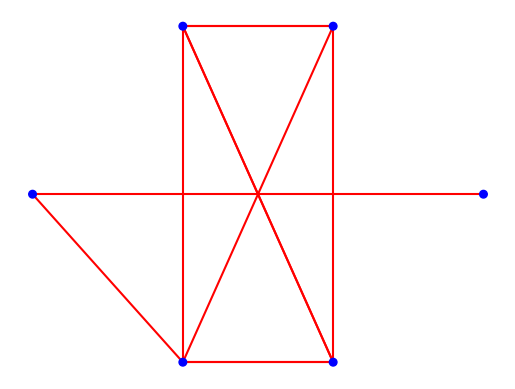

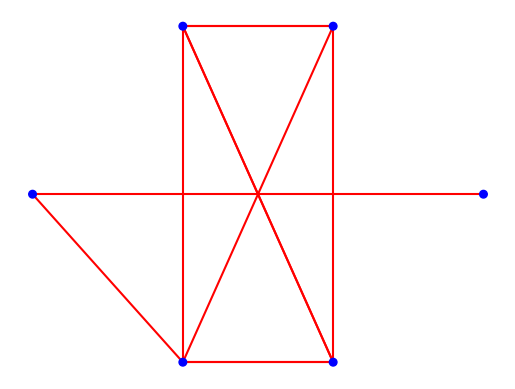

In [36]:
tedges = [('a', 'b', 1),('a', 'b', 2), ('b', 'a', 3), ('b', 'c', 3), ('d', 'c', 4), ('a', 'b', 4), ('c', 'b', 4),
              ('c', 'd', 5), ('b', 'a', 5), ('c', 'b', 6), ('a', 'c', 6), ('b', 'd', 6), ('a', 'd', 6), ('e', 'f', 6), ('a','e',1)]
test_graph = pp.TemporalGraph.from_edge_list(tedges)
test_layout= {'a':[1,0], 'b':[2,0], 'c':[1,2], 'd':[2,2], 'e': [0, 1], 'f': [3, 1]}

# create PathData object with same structure
m = pp.MultiOrderModel.from_temporal_graph(test_graph, 1, 6, cached=True)
test_paths = pp.PathData(test_graph.mapping)

for i in range(2,7):
   for node in list(m.layers[i].nodes):
        if(len(list(node)) == len(set(list(node)))):
                test_paths.append_walk(list(node))

for i in range(test_paths.num_paths):
     print(test_paths.get_walk(i))

pp.plot(test_graph.to_static_graph(), layout=test_layout, backend="matplotlib")

test_m = pp.MultiOrderModel.from_PathData(test_paths, 2, cached=True)
pp.plot(test_m.layers[1], layout=test_layout, backend="matplotlib")

In [37]:
print(edge_crossing_compromise(test_graph, test_layout))

tensor(5.)


# New Shortest Paths Implementation

Anmerkung: Macht kein Sinn, da resultierende shortest Paths nicht unbedingt existent!

In [38]:
def get_shortest_paths_as_pathdata_slow(graph, delta):
    dist, pred = pp.algorithms.temporal_shortest_paths(graph, delta)
    paths = pp.PathData(graph.mapping)
    for node_i in range(graph.n):
           for node_j in range(graph.n):
                if dist[node_i, node_j] > 0 and pred[node_i, node_j] != -1:
                    # initialize path
                    causal_path = [graph.mapping.to_id(node_j)]
                    current_node = node_j

                    # append predecessor\n",
                    while pred[node_i, current_node] != node_i:
                            current_node = pred[node_i, current_node]
                            causal_path.insert(0, graph.mapping.to_id(current_node))

                    # insert starting node
                    causal_path.insert(0, graph.mapping.to_id(node_i))
                    # add path to set of paths
                    paths.append_walk(causal_path)

    return paths

def get_shortest_paths_as_pathdata(graph, delta):

    dist, pred = pp.algorithms.temporal_shortest_paths(graph, delta)
    dist = torch.tensor(dist)
    pred = torch.tensor(pred)

    paths = pp.PathData(graph.mapping)

    causal_paths = [[None]*graph.n] * graph.n

    idxs = torch.nonzero(dist == 1)
    for idx1, idx2 in idxs:
         causal_paths[idx1][idx2] = [graph.mapping.to_id(idx1)] + [graph.mapping.to_id(idx2)]
         paths.append_walk(causal_paths[idx1][idx2])
         
    for i in range(2,graph.n+1):
        idxs = torch.nonzero(dist == i)
        for idx1, idx2 in idxs:
            predecessor = pred[idx1, idx2]
            causal_paths[idx1][idx2] = causal_paths[idx1][predecessor] + [graph.mapping.to_id(idx2)]
            paths.append_walk(causal_paths[idx1][idx2])

    return paths

In [39]:
paths = get_shortest_paths_as_pathdata(test_graph, 1)
for i in range(paths.num_paths):
     print(paths.get_walk(i))
paths = get_shortest_paths_as_pathdata_slow(test_graph, 1)
for i in range(paths.num_paths):
     print(paths.get_walk(i))

100%|██████████| 6/6 [00:00<00:00, 2046.17it/s]


('a', 'b')
('a', 'c')
('a', 'd')
('a', 'e')
('b', 'a')
('b', 'c')
('b', 'd')
('c', 'b')
('c', 'd')
('d', 'c')
('e', 'f')
('c', 'b', 'a')


100%|██████████| 6/6 [00:00<00:00, 2035.91it/s]


('a', 'b')
('a', 'c')
('a', 'd')
('a', 'e')
('b', 'a')
('b', 'c')
('b', 'd')
('c', 'b', 'a')
('c', 'b')
('c', 'd')
('d', 'c')
('e', 'f')


## Get random walks on temporal graph

In [40]:
def random_walk_temporal_graph(graph: pp.TemporalGraph, delta: int = 1, steps: list = [10], runs: list = [1]):
    # create higher order model of order 2
    g_ho = pp.MultiOrderModel.from_temporal_graph(graph, delta = delta, max_order=2, cached=False).layers[2]
    # get instance of RandomWalk
    rw = pp.processes.RandomWalk(g_ho, weight='edge_weight', restart_prob=0.0)
    # get instance of PathData
    paths = pp.PathData(graph.mapping)
    # for every step number and corresponding run number
    for s,r in zip(steps, runs):
        # create r paths on higher order model with s-1 steps
        current_steps_paths = rw.get_paths(rw.run_experiment(steps=s-1, runs=r))
        # for every path
        for idx in range(current_steps_paths.num_paths):
            # get path
            current_path_ho = current_steps_paths.get_walk(idx)
            # start curret path with nodes of first node in higher order model
            current_path = [current_path_ho[0][0], current_path_ho[0][1]]
            # iterate through higher order path as long as it is a real path (sometimes we jump anywhere in case there is no other possibility)
            i = 1
            while i < len(current_path_ho) and (current_path_ho[i][0] == current_path[-1]):
                    # check if we stayed on the same node -> skip
                    if not current_path_ho[i][0] == current_path_ho[i][1]:
                        # append node
                        current_path.append(current_path_ho[i][1])
                    i += 1
            # created append path to PathData object
            paths.append_walk(current_path)
            
    return paths

In [41]:
paths = random_walk_temporal_graph(graph, runs=[100])
for idx in range(paths.num_paths):
    print(paths.get_walk(idx))

100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


('18', '12', '17', '12', '18', '19', '20', '10', '29', '0', '26')
('1', '17', '1', '23', '17', '7', '26', '14', '25', '19', '5')
('21', '20', '29', '22', '21', '23', '26', '27', '25', '29')
('25', '18', '29', '18', '21', '20', '29', '21', '26', '20')
('17', '3', '16', '22', '5', '22', '0', '23', '4', '13', '2')
('12', '14', '12', '4', '6', '0', '1', '7', '1', '4', '12')
('17', '4', '27', '19', '21', '18', '3', '16', '4', '18', '3')
('22', '23', '28', '18', '25', '18', '28', '19', '24', '15', '27')
('23', '19', '27', '3', '2', '5', '7', '9', '6', '20', '19')
('0', '26', '13', '2', '25', '14', '22', '9', '22', '9', '26')
('15', '4', '20', '16', '7', '27', '7', '27', '9', '23', '14')
('10', '29', '0', '14', '5', '10', '20', '26', '20', '26', '14')
('14', '13', '14', '11', '21', '13', '0', '12', '21', '15', '4')
('26', '8', '17', '2', '17', '8', '14', '4', '19', '29', '0')
('15', '28', '21', '27', '28', '25', '23', '21', '23')
('25', '13', '5', '15', '1', '22', '10', '18', '13', '17', '15'